In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv
/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/1/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/1/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/1/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/1/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/1/assets/tokenizer/vocabulary.txt
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
# Importing libraries for basic visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Importing Tensorflow 
import tensorflow as tf
from tensorflow import keras
import keras_nlp
print('Tensorflow Version:', tf.__version__)

Using TensorFlow backend
Tensorflow Version: 2.13.0


In [3]:
trn_data = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
trn_data.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


Text(0.5, 1.0, 'Distribution of prompt ID')

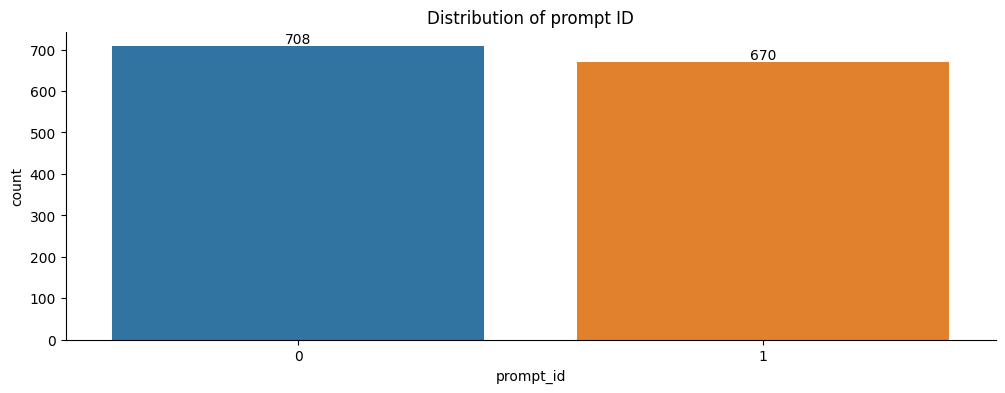

In [4]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=trn_data,
                   x="prompt_id")

abs_values = trn_data['prompt_id'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")

In [5]:
trn_data['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

Most of the text is written is by humans(1375) and that of AI is very small(3).

Text(0.5, 1.0, 'Distribution of Generated Text')

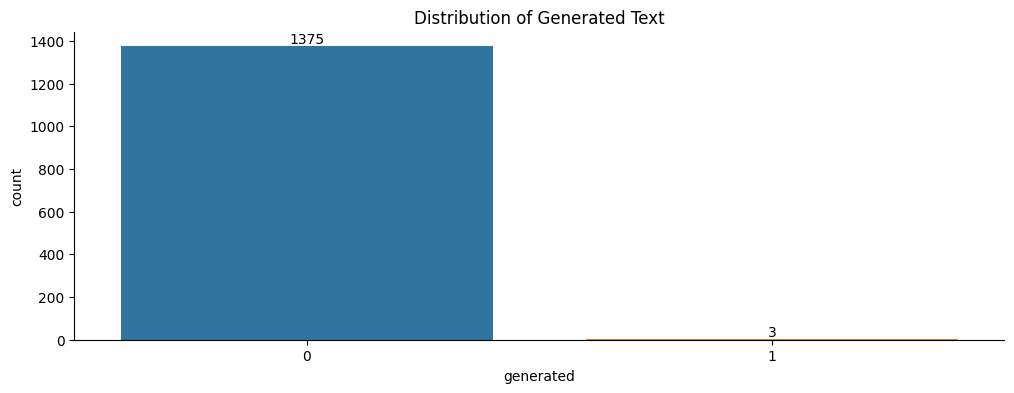

In [6]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=trn_data,
                   x="generated")

abs_values = trn_data['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

since there is a lot of unbalanced data present in the train data, applying balancing methods will only lead to overfitting of the data, which will lead to wrong prediction.

In [7]:
# Reading prompt file to check the data 
prompt_dta = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
prompt_dta.head()
# It only contains two propmts.

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [8]:
# Reading test data
tst_data = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
tst_data.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [9]:
tst_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes


### Adding New data to train

In [10]:
df_train_essays_ext = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv')
df_train_essays_ext.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [11]:
# Renaming the label column to generated as it will be easy to concatenate in further steps.
df_train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)

Text(0.5, 1.0, 'Distribution of Prompt Name')

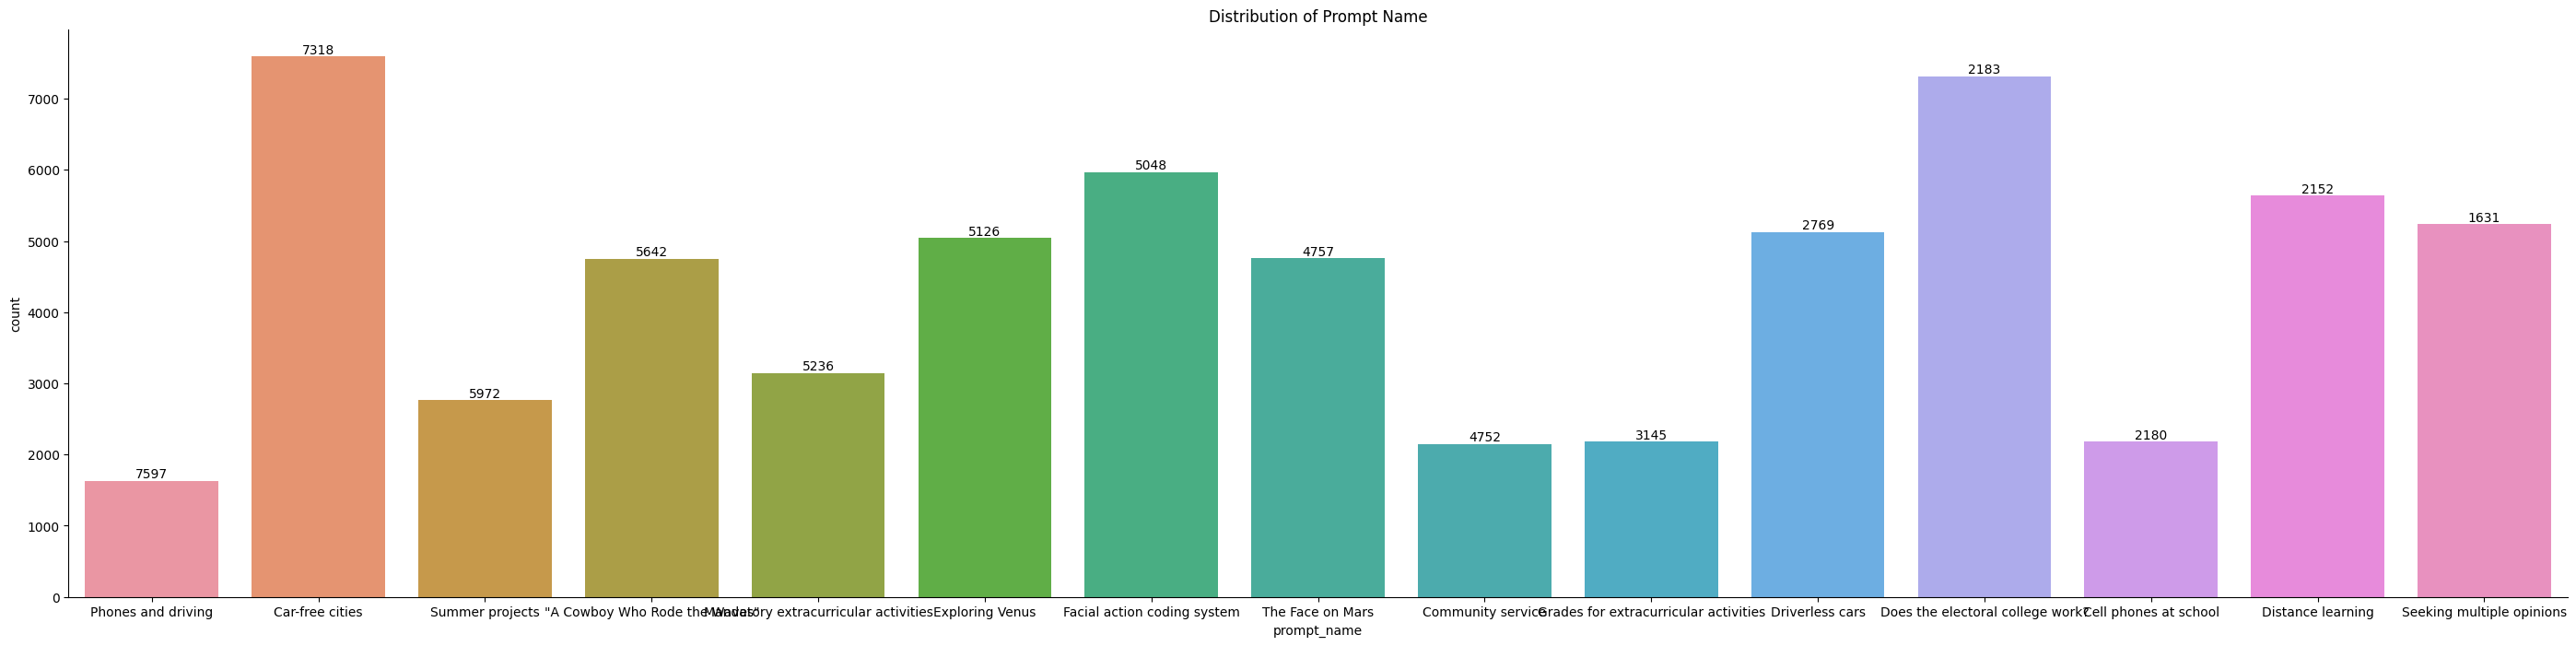

In [12]:
f, ax = plt.subplots(figsize=(35, 8))

sns.despine()
ax = sns.countplot(data=df_train_essays_ext,
                   x="prompt_name")

abs_values = df_train_essays_ext['prompt_name'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Prompt Name")

Text(0.5, 1.0, 'Distribution of Labels')

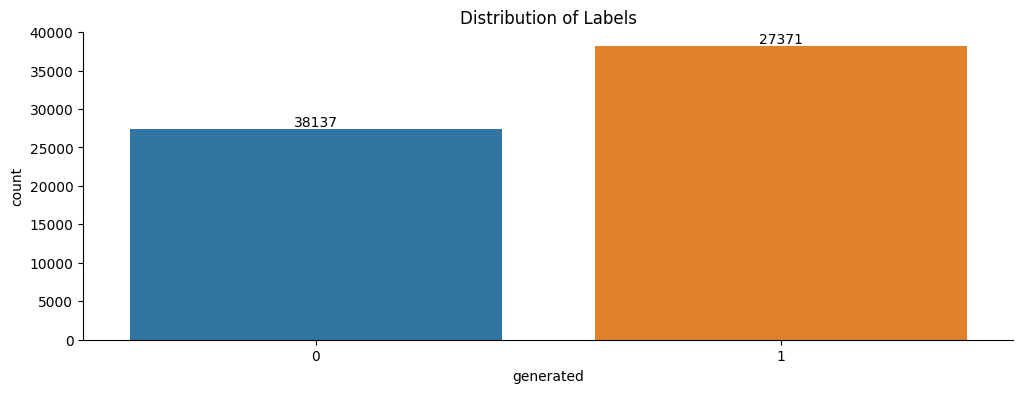

In [13]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_ext,
                   x="generated")

abs_values = df_train_essays_ext['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Labels")

Here, the count of Human written text is less than that of AI generated text, so we will concatenate this data to our train dataset.

In [14]:
trn_essays_final_data = pd.concat([df_train_essays_ext[["text", "generated"]], trn_data[["text", "generated"]]])
trn_essays_final_data.head()

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


In [15]:
trn_essays_final_data['generated'].value_counts()

generated
1    38140
0    28746
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Generated Text')

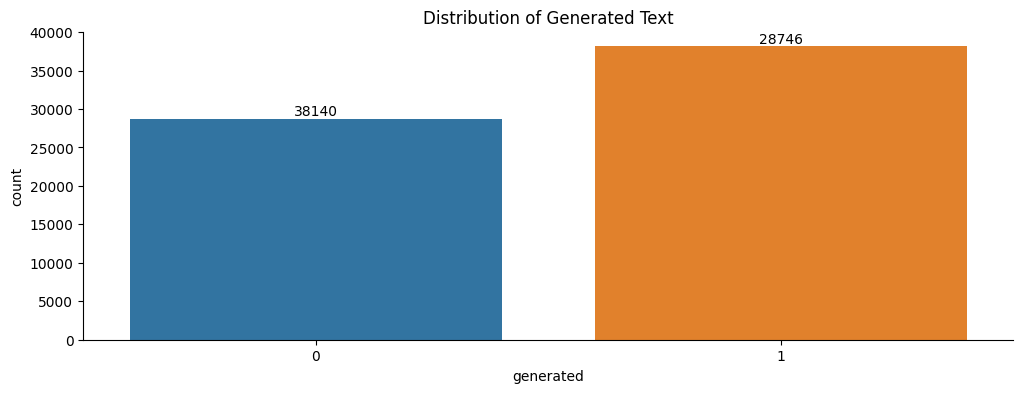

In [16]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=trn_essays_final_data,
                   x="generated")

abs_values = trn_essays_final_data['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

Now, finally we can see that the long difference between human and AI generated text is reduced.

In [17]:
trn_essays_final_data.shape

(66886, 2)

In [18]:
# Checking null existance in data
trn_essays_final_data.isnull().sum()

text         148
generated      0
dtype: int64

In [19]:
# Filling nulls with blank space
trn_essays_final_data = trn_essays_final_data.fillna('')

I am not doing any type of text cleaning as I think when classifying between the Human and AI text it should be presented as it is so that in real time it can predict with more preicision.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
all_data = pd.concat([trn_essays_final_data['text'], tst_data['text']])

# Fit the TfidfVectorizer on the entire dataset
tfidf = TfidfVectorizer()
tfidf.fit(all_data)
vect_x_trn = tfidf.transform(trn_essays_final_data['text'])
vect_tst_data = tfidf.transform(tst_data['text'])

In [21]:
from sklearn.model_selection import train_test_split
X_trn, X_tst, Y_trn, Y_tst = train_test_split(vect_x_trn, trn_essays_final_data['generated'], test_size=0.2, shuffle=True, random_state=41)

In [22]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_trn, Y_trn)

LogisticRegression()

In [23]:
from sklearn.metrics import f1_score
log_pred = logreg.predict(X_tst)
print(f'F1 Score: {f1_score(Y_tst, log_pred)*100}')

F1 Score: 99.05316824471959


In [24]:
samp = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

In [25]:
final_pred = logreg.predict_proba(vect_tst_data)[:, 1]
samp['generated'] = final_pred
samp.to_csv('submission.csv', index=False)

In [26]:
samp

,id,generated
0,0000aaaa,0.962999
1,1111bbbb,0.963637
2,2222cccc,0.963637
